In [1]:
# Importing the necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset
medic_insure = pd.read_csv('/content/drive/MyDrive/insurance.csv')

In [4]:
# The first Ten Elements
medic_insure.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [5]:
# General info of the dataset
medic_insure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
# Shape of the dataset
medic_insure.shape

(1338, 7)

In [7]:
# Summary Statistics
medic_insure.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [8]:
# Put the columns into a list
full_cols = medic_insure.columns
full_cols.to_list()

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [9]:
# Seperate Numerical Columns from Categorical Columns
num_cols = full_cols[medic_insure.dtypes != 'object']
cat_cols = full_cols[medic_insure.dtypes == 'object']
print(num_cols)
print(cat_cols)

Index(['age', 'bmi', 'children', 'charges'], dtype='object')
Index(['sex', 'smoker', 'region'], dtype='object')


In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [20]:
# make a copy of the dataset
med_insure = medic_insure.copy()

## Define Classification Target


Create a new categorical target variable from the 'charges' column by binning it into meaningful categories (e.g., 'low', 'medium', 'high' medical charges). This will convert the regression problem into a classification problem.


In [21]:
num_bins = 3
labels = ['low', 'medium', 'high']

medic_insure['charges_category'] = pd.qcut(medic_insure['charges'], q=num_bins, labels=labels)

print(medic_insure['charges_category'].value_counts())

charges_category
low       446
medium    446
high      446
Name: count, dtype: int64


In [22]:
y = medic_insure['charges_category']
X = medic_insure.drop(['charges', 'charges_category'], axis=1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("X head:\n", X.head())
print("y head:\n", y.head())

Shape of X: (1338, 6)
Shape of y: (1338,)
X head:
    age     sex     bmi  children smoker     region
0   19  female  27.900         0    yes  southwest
1   18    male  33.770         1     no  southeast
2   28    male  33.000         3     no  southeast
3   33    male  22.705         0     no  northwest
4   32    male  28.880         0     no  northwest
y head:
 0    high
1     low
2     low
3    high
4     low
Name: charges_category, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']


In [25]:
# Categorical and Numerical Features
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(include=['float64', 'int64']).columns

In [26]:
cat_features, num_features

(Index(['sex', 'smoker', 'region'], dtype='object'),
 Index(['age', 'bmi', 'children'], dtype='object'))

In [27]:
scale = StandardScaler()
encoder = OneHotEncoder(handle_unknown = 'ignore')

# column transformer
preprocessor = ColumnTransformer(
    transformers = [
       ('num_scale', scale, num_features),
        ('cat_encode', encoder, cat_features)
    ]
)

## Split Data

Divide the raw features (X) and target (y) into training and testing sets before applying the full preprocessing pipeline, to prevent data leakage.


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1070, 6)
X_test shape: (268, 6)
y_train shape: (1070,)
y_test shape: (268,)


## Model Pipelines


Create a dictionary where each key is a model name (e.g., 'Logistic Regression', 'Decision Tree', 'Random Forest') and each value is a Pipeline object that combines the preprocessor with the respective classifier. Then, train each pipeline in the dictionary on the training data.


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [30]:
log_reg = LogisticRegression(solver='liblinear', random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

pipelines = {
    'Logistic Regression': Pipeline(
        steps=[('preprocessor', preprocessor),
         ('classifier', log_reg)]),

    'Decision Tree': Pipeline(
        steps=[('preprocessor', preprocessor),
         ('classifier', dt_clf)]),

    'Random Forest': Pipeline(
        steps=[('preprocessor', preprocessor),
         ('classifier', rf_clf)])
}

for model_name, pipeline in pipelines.items():
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)
    print(f"{model_name} training complete.")

Training Logistic Regression...
Logistic Regression training complete.
Training Decision Tree...
Decision Tree training complete.
Training Random Forest...
Random Forest training complete.


## Evaluate All Model Pipelines

Iterate through the dictionary of trained model pipelines, make predictions on the test data for each, and evaluate their performance using appropriate classification metrics (accuracy, precision, recall, F1-score).


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [32]:
results = {}

for model_name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\n")

--- Logistic Regression ---
Accuracy: 0.8507
Precision: 0.8798
Recall: 0.8507
F1-Score: 0.8481


--- Decision Tree ---
Accuracy: 0.8582
Precision: 0.8582
Recall: 0.8582
F1-Score: 0.8582


--- Random Forest ---
Accuracy: 0.8806
Precision: 0.8835
Recall: 0.8806
F1-Score: 0.8804




## Comparing All Pipeline Models




In [33]:
best_model_per_metric = {
    'Accuracy': {'model': None, 'score': -1},
    'Precision': {'model': None, 'score': -1},
    'Recall': {'model': None, 'score': -1},
    'F1-Score': {'model': None, 'score': -1}
}

for model_name, metrics in results.items():
    for metric_name, score in metrics.items():
        if score > best_model_per_metric[metric_name]['score']:
            best_model_per_metric[metric_name]['score'] = score
            best_model_per_metric[metric_name]['model'] = model_name

print("Best model per metric:")
for metric, data in best_model_per_metric.items():
    print(f"{metric}: {data['model']} with score {data['score']:.4f}")

Best model per metric:
Accuracy: Random Forest with score 0.8806
Precision: Random Forest with score 0.8835
Recall: Random Forest with score 0.8806
F1-Score: Random Forest with score 0.8804


## Hyperparameter Tuning and Cross-Validation for Best Model

Perform hyperparameter tuning on the best-performing model (Random Forest) using techniques like GridSearchCV, combined with cross-validation, to find the optimal parameters and evaluate its robustness.


In [34]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [10, 20, 30, None] # None means full depth
}

In [35]:
grid_search = GridSearchCV(pipelines['Random Forest'], param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_scale',
                                                                         StandardScaler(),
                                                                         Index(['age', 'bmi', 'children'], dtype='object')),
                                                                        ('cat_encode',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['sex', 'smoker', 'region'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30, None],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [36]:
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}


In [37]:
print("Best cross-validation score:", grid_search.best_score_)

Best cross-validation score: 0.8981308411214954


## Summary:

### Q&A

This analysis aimed to transform a regression problem (predicting medical charges) into a classification problem by categorizing charges into 'low', 'medium', and 'high'. We then built, evaluated, and compared three classification models: Logistic Regression, Decision Tree Classifier, and Random Forest Classifier. Finally, we performed hyperparameter tuning and cross-validation on the best-performing model.

### Data Analysis Key Findings

1.  **Classification Target:** The 'charges' column was successfully binned into a categorical 'charges_category' with 'low', 'medium', and 'high' labels. `pd.qcut` ensured an even distribution, with 446 observations in each category.
2.  **Feature and Target Separation:** Features (X) included 'age', 'sex', 'bmi', 'children', 'smoker', and 'region', while the target (y) was 'charges_category'. X had a shape of (1338, 6) and y a shape of (1338,).
3.  **Preprocessing Pipeline:** A `ColumnTransformer` was used to create a robust preprocessing pipeline. Numerical features ('age', 'bmi', 'children') were scaled using `StandardScaler`, and categorical features ('sex', 'smoker', 'region') were one-hot encoded using `OneHotEncoder`.
4.  **Data Splitting:** The data was split into training (80%) and testing (20%) sets, resulting in `X_train` (1070, 6), `X_test` (268, 6), `y_train` (1070,), and `y_test` (268,) to prevent data leakage and ensure fair model evaluation.
5.  **Model Training and Evaluation:** Three `Pipeline` objects, each combining the preprocessor with a classifier, were trained and evaluated:
    *   **Logistic Regression:** Accuracy: 0.8507, Precision: 0.8798, Recall: 0.8507, F1-Score: 0.8481
    *   **Decision Tree Classifier:** Accuracy: 0.8582, Precision: 0.8582, Recall: 0.8582, F1-Score: 0.8582
    *   **Random Forest Classifier:** Accuracy: 0.8806, Precision: 0.8835, Recall: 0.8806, F1-Score: 0.8804

6.  **Model Comparison:** The Random Forest Classifier emerged as the best-performing model, consistently achieving the highest scores across all metrics (Accuracy, Precision, Recall, F1-Score) compared to Logistic Regression and Decision Tree.

7.  **Hyperparameter Tuning:** Hyperparameter tuning was performed on the Random Forest pipeline using `GridSearchCV` with `param_grid` including `n_estimators`, `max_features`, and `max_depth`. The best parameters found were `{'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}`.

8.  **Optimized Random Forest Performance:** The best cross-validation score after tuning was 0.8981.

### Insights

*   **Optimal Model Selection:** The **Random Forest Classifier** is the most suitable model for classifying medical charges into 'low', 'medium', and 'high' categories, demonstrating superior and more robust performance, especially after hyperparameter tuning and cross-validation.
*   **Robustness of Ensemble Methods:** The improved performance of the Random Forest model confirms the effectiveness of ensemble learning for this dataset, as it handles the complexity and non-linear relationships better than simpler models.
*   **Impact of Tuning:** Hyperparameter tuning further improved the Random Forest model's performance, indicating the importance of optimizing model parameters for real-world applications.


## Feature Importance Analysis for Best Model

Extract and visualize the feature importances from the best-performing, tuned Random Forest model to identify the most influential features in predicting medical charge categories.


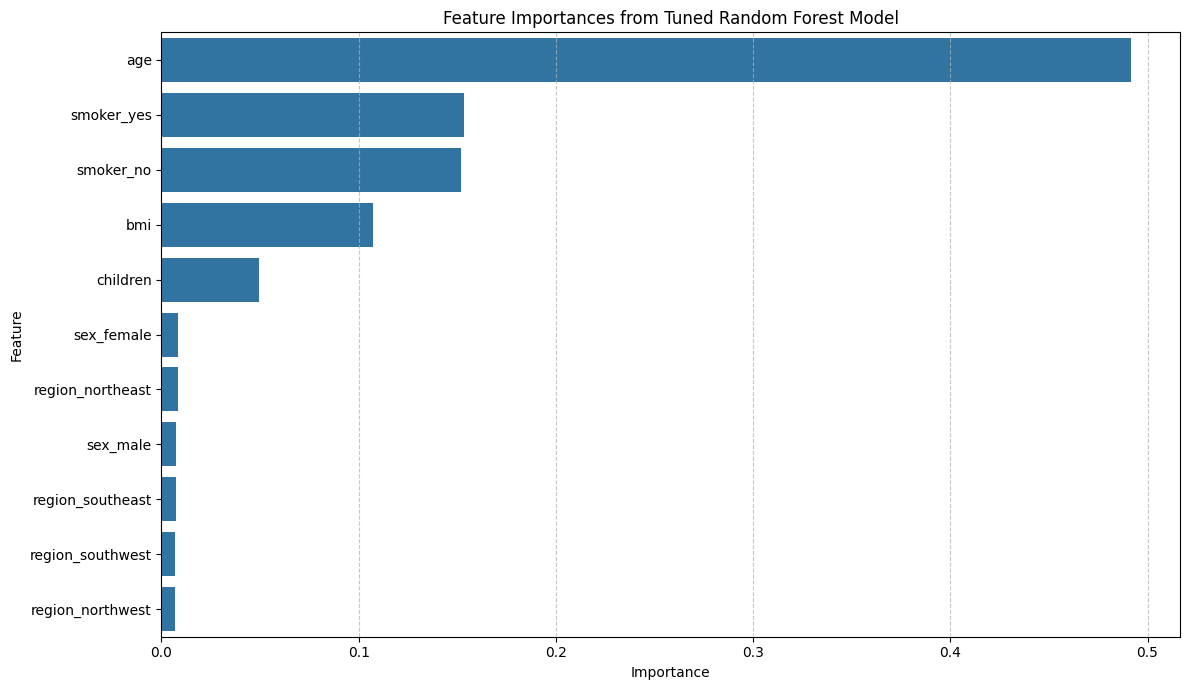

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Extract the best estimator from the grid_search object
best_pipeline = grid_search.best_estimator_

# 2. Access the RandomForestClassifier from the best estimator pipeline
rf_model = best_pipeline.named_steps['classifier']

# 3. Extract the feature importances
feature_importances = rf_model.feature_importances_

# 4. Get the names of the numerical features (already available as num_features)

# 5. Get the names of the one-hot encoded categorical features
onehot_encoder = best_pipeline.named_steps['preprocessor'].named_transformers_['cat_encode']
cat_feature_names = onehot_encoder.get_feature_names_out(cat_features)

# 6. Combine the numerical and categorical feature names
all_feature_names = list(num_features) + list(cat_feature_names)

# 7. Create a Pandas DataFrame that maps each feature name to its importance score
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# 8. Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 9. Create a bar plot to visualize the feature importances
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Tuned Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings
*   The best-performing, tuned Random Forest model from the `GridSearchCV` object was successfully extracted.
*   Feature importances were extracted from the `RandomForestClassifier` within the best estimator pipeline.
*   Both numerical and one-hot encoded categorical feature names were combined to create a comprehensive list of all features.
*   A DataFrame was created, mapping each feature name to its corresponding importance score, and then sorted in descending order of importance.
*   A bar plot was generated to visually represent the feature importances, clearly identifying the most influential features in predicting medical charge categories.

